In [ ]:
import torch
import torchaudio
import random

### 데이터 로드

In [3]:
clean_path = './data/LibriSpeech/train-clean-100/19/198/19-198-0000.flac'
clean_wave, clean_rate = torchaudio.load(clean_path)

noise_path = './data/noise_datasets/urbansound8k/audio/fold1/7061-6-0-0.wav'
noise_wave, noise_rate = torchaudio.load(noise_path)

print(clean_wave.shape, clean_rate)
print(noise_wave.shape, noise_rate)

torch.Size([1, 31440]) 16000
torch.Size([2, 99225]) 44100


### sampling rate 통일

In [4]:
noise_wave = torchaudio.transforms.Resample(orig_freq = noise_rate, new_freq = clean_rate)(noise_wave)
print(noise_wave.shape)  # 99225 * (16000/44100)

torch.Size([2, 36000])


### 채널 수 통일

In [5]:
noise_wave = torch.mean(noise_wave, dim = 0, keepdim = True)
print(noise_wave.shape)

torch.Size([1, 36000])


### 두 오디오 길이 통일

In [6]:
clean_len = clean_wave.shape[-1]
print(clean_len)

noise_len = noise_wave.shape[-1]
print(noise_len)

31440
36000


In [7]:
if clean_len > noise_len:
    repeat_factor = clean_len // noise_len + 1
    noise_wave = torch.cat([noise_wave] * repeat_factor, dim = 1)
    noise_wave = noise_wave[..., :clean_len ]

elif clean_len < noise_len:
    start_idx = random.randint(0, noise_len - clean_len)
    noise_wave = noise_wave[..., start_idx:start_idx + clean_len]

else: clean_wave, noise_wave

print(clean_wave.shape)
print(noise_wave.shape)

torch.Size([1, 31440])
torch.Size([1, 31440])


### Mixing 비율 설정

In [8]:
def calculate_alpha(clean, noise, target_snr_dB):  # target_snr : dB 단위
    P_clean = torch.mean(clean ** 2) + 1e-9
    P_noise = torch.mean(noise ** 2) + 1e-9
    target_ratio = 10 ** (target_snr_dB/10.0)  # dB -> 일반적인 비율로 변환
    alpha = torch.sqrt(P_clean / P_noise * target_ratio)

    return alpha

### Mixing

In [9]:
def mix(clean, noise, target_snr_dB):
    alpha = calculate_alpha(clean, noise, target_snr_dB)
    scaled_noise = alpha * noise
    mixed_audio = clean + scaled_noise
    
    return mixed_audio, clean, target_snr_dB

In [10]:
snr_dB = random.uniform(0, 15)
mixed_audio, clean_wave, target_snr_dB = mix(clean_wave, noise_wave, snr_dB)
print(snr_dB)
print(mixed_audio, mixed_audio.shape)
print(clean_wave, clean_wave.shape)

4.291954742434362
tensor([[-0.1117,  0.1694,  0.2169,  ...,  0.0069,  0.0081,  0.0075]]) torch.Size([1, 31440])
tensor([[0.0044, 0.0033, 0.0031,  ..., 0.0047, 0.0060, 0.0060]]) torch.Size([1, 31440])


In [11]:
torchaudio.save('mixed_audio_example.flac', mixed_audio, clean_rate)

<function matplotlib.pyplot.show(close=None, block=None)>

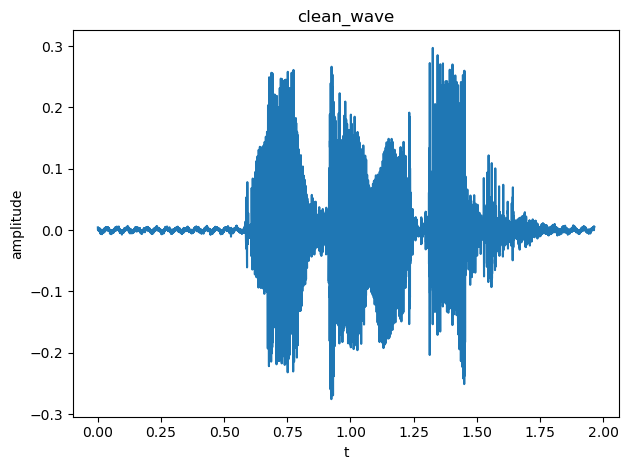

In [12]:
import matplotlib.pyplot as plt
import numpy as np

clean_wave_1d = clean_wave.squeeze().numpy()
time = np.arange(len(clean_wave_1d)) / clean_rate
plt.plot(time, clean_wave_1d)
plt.title('clean_wave')
plt.xlabel('t')
plt.ylabel('amplitude')
plt.tight_layout()
plt.show


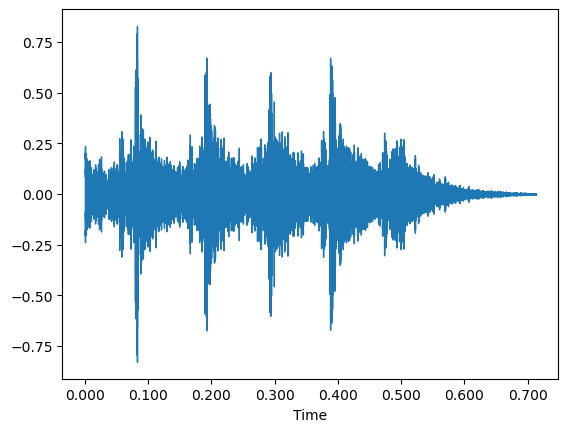

In [15]:
import librosa

noise_wave_1d = noise_wave.squeeze().numpy()
time = np.arange(len(noise_wave_1d)) / noise_rate
librosa.display.waveshow(noise_wave_1d, sr=noise_rate)


<function matplotlib.pyplot.show(close=None, block=None)>

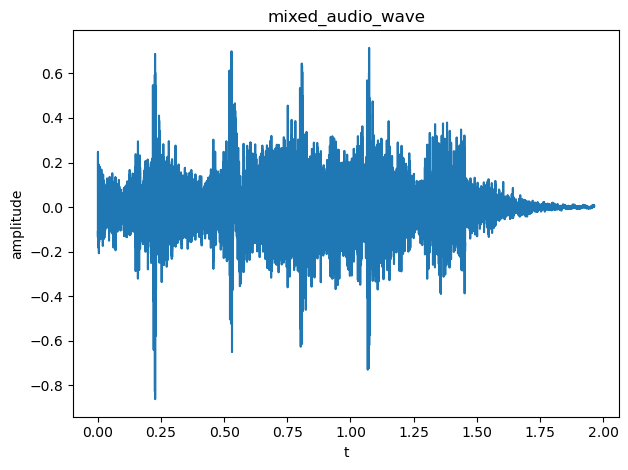

In [14]:
mixed_audio_1d = mixed_audio.squeeze().numpy()
time = np.arange(len(mixed_audio_1d)) / clean_rate
plt.plot(time, mixed_audio_1d)
plt.title('mixed_audio_wave')
plt.xlabel('t')
plt.ylabel('amplitude')
plt.tight_layout()
plt.show